In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import cv2
import matplotlib.cm as cm

In [4]:
print("Vérification GPU...")
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté.")
else:
    print("Aucun GPU détecté, l'entraînement se fera sur le CPU.")

Vérification GPU...
Aucun GPU détecté, l'entraînement se fera sur le CPU.


In [7]:
img_size = 128
batch_size = 32
epochs = 20
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'
n_folds = 10

In [13]:
def load_data(data_dir1, data_dir2, limit=100):
    print("Chargement des données...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Échec de la lecture de {img}. Passage au suivant.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Chargement des données terminé.")
    return np.array(data, dtype=object)

train_data = load_data(data_dir1, data_dir2, limit=100)

Chargement des données...
Chargement des données terminé.


In [15]:
# Prétraiter les images
def preprocess_image(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0  # Normalisation après redimensionnement
    return image

# Prétraiter les données
def preprocess_data(data):
    print("Prétraitement des données...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        print(f"Traitement de l'image {idx+1}/{len(data)}")
        img = preprocess_image(img)
        processed_data.append([img, label])
    return np.array(processed_data, dtype=object)

train_data = preprocess_data(train_data)

Prétraitement des données...
Traitement de l'image 1/200
Traitement de l'image 2/200
Traitement de l'image 3/200
Traitement de l'image 4/200
Traitement de l'image 5/200
Traitement de l'image 6/200
Traitement de l'image 7/200
Traitement de l'image 8/200
Traitement de l'image 9/200
Traitement de l'image 10/200
Traitement de l'image 11/200
Traitement de l'image 12/200
Traitement de l'image 13/200
Traitement de l'image 14/200
Traitement de l'image 15/200
Traitement de l'image 16/200
Traitement de l'image 17/200
Traitement de l'image 18/200
Traitement de l'image 19/200
Traitement de l'image 20/200
Traitement de l'image 21/200
Traitement de l'image 22/200
Traitement de l'image 23/200
Traitement de l'image 24/200
Traitement de l'image 25/200
Traitement de l'image 26/200
Traitement de l'image 27/200
Traitement de l'image 28/200
Traitement de l'image 29/200
Traitement de l'image 30/200
Traitement de l'image 31/200
Traitement de l'image 32/200
Traitement de l'image 33/200
Traitement de l'image 3

In [19]:
# Séparer les caractéristiques et les étiquettes
def separate_features_labels(data):
    images = np.array([item[0] for item in data])
    labels = np.array([item[1] for item in data])
    return images, labels

x_train, y_train = separate_features_labels(train_data)
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_train = np.concatenate([x_train, x_train, x_train], axis=-1) 

In [21]:
# Fonction pour définir le modèle CNN
def create_model():
    print("Définition du modèle...")
    model = Sequential([
        Conv2D(2, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(4, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(8, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    print("Modèle défini.")
    print("Compilation du modèle...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    print("Modèle compilé")
    model.build(input_shape=(None, img_size, img_size, 3))
    print("Modèle construit")
    print("Résumé du modèle :")
    print(model.summary())
    return model

# Validation croisée K-Fold
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold = 1
fold_accuracies = []

for train_index, val_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    print(f"Traitement du pli {fold}/{n_folds}")
    datagen = ImageDataGenerator(zoom_range=0.1, shear_range=0.1)
    datagen.fit(x_train_fold)
    
    model = create_model()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[reduce_lr, early_stop])
    
    # Évaluer le modèle pour ce pli
    scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Précision de validation pour le pli {fold}: {scores[1]*100:.2f}%")
    print(f"Perte de validation pour le pli {fold}: {scores[0]:.4f}")
    fold_accuracies.append(scores[1])

Traitement du pli 1/10
Définition du modèle...


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modèle défini.
Compilation du modèle...
Modèle compilé
Modèle construit
Résumé du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.4868 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5678 - loss: 0.6874 - val_accuracy: 0.5000 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4863 - loss: 0.6875 - val_accuracy: 0.5000 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6418 - loss: 0.6710 - val_accuracy: 0.5000 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6133 - loss: 0.6657 - val_accuracy: 0.5500 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6885 - loss: 0.6297 - val_accuracy: 0.6500 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.7267 - loss: 0.5827 - val_accuracy: 0.8500 - val_los

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.5175 - loss: 0.6903 - val_accuracy: 0.4500 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4884 - loss: 0.6810 - val_accuracy: 0.4500 - val_loss: 0.6655 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5046 - loss: 0.6697 - val_accuracy: 0.4500 - val_loss: 0.6511 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5560 - loss: 0.6383 - val_accuracy: 0.5500 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7390 - loss: 0.6162 - val_accuracy: 0.5500 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7518 - loss: 0.5434 - val_accuracy: 0.7000 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8436 - loss: 0.4704 - val_accuracy: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.4820 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5405 - loss: 0.6827 - val_accuracy: 0.5000 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4953 - loss: 0.6828 - val_accuracy: 0.6000 - val_loss: 0.6636 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5948 - loss: 0.6708 - val_accuracy: 0.6000 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6590 - loss: 0.6532 - val_accuracy: 0.6000 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5917 - loss: 0.6224 - val_accuracy: 0.8000 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8254 - loss: 0.5877 - val_accuracy: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.5157 - loss: 0.6938 - val_accuracy: 0.5500 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5278 - loss: 0.6820 - val_accuracy: 0.5500 - val_loss: 0.6692 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5527 - loss: 0.6618 - val_accuracy: 0.5500 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6618 - loss: 0.6622 - val_accuracy: 0.5500 - val_loss: 0.6268 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6798 - loss: 0.6154 - val_accuracy: 0.6000 - val_loss: 0.5939 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7276 - loss: 0.6211 - val_accuracy: 0.7000 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8118 - loss: 0.5621 - val_accuracy: 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.5745 - loss: 0.6968 - val_accuracy: 0.4500 - val_loss: 0.7097 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4995 - loss: 0.6777 - val_accuracy: 0.8500 - val_loss: 0.6667 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5826 - loss: 0.6770 - val_accuracy: 0.7000 - val_loss: 0.6434 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6045 - loss: 0.6626 - val_accuracy: 0.8000 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6385 - loss: 0.6325 - val_accuracy: 0.8000 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7520 - loss: 0.6076 - val_accuracy: 0.9000 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8001 - loss: 0.5256 - val_accuracy: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.5470 - loss: 0.6916 - val_accuracy: 0.5500 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4844 - loss: 0.6846 - val_accuracy: 0.5500 - val_loss: 0.6675 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4983 - loss: 0.6705 - val_accuracy: 0.5500 - val_loss: 0.6497 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4760 - loss: 0.6762 - val_accuracy: 0.5500 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5419 - loss: 0.6408 - val_accuracy: 0.5500 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5919 - loss: 0.6144 - val_accuracy: 0.8500 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8625 - loss: 0.5814 - val_accuracy: 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.5747 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5459 - loss: 0.6876 - val_accuracy: 0.5000 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5398 - loss: 0.6782 - val_accuracy: 0.5000 - val_loss: 0.6677 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4885 - loss: 0.6445 - val_accuracy: 0.5000 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5509 - loss: 0.5901 - val_accuracy: 0.5000 - val_loss: 0.6554 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6726 - loss: 0.5850 - val_accuracy: 0.5000 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7033 - loss: 0.5568 - val_accuracy: 0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5505 - loss: 0.6936 - val_accuracy: 0.4000 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5121 - loss: 0.6806 - val_accuracy: 0.4000 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5573 - loss: 0.6650 - val_accuracy: 0.4500 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6154 - loss: 0.6322 - val_accuracy: 0.5000 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6963 - loss: 0.5791 - val_accuracy: 0.7000 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8735 - loss: 0.5182 - val_accuracy: 0.7000 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8457 - loss: 0.4258 - val_accuracy: 0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.4777 - loss: 0.6946 - val_accuracy: 0.5500 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4783 - loss: 0.6851 - val_accuracy: 0.5500 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5117 - loss: 0.6656 - val_accuracy: 0.6000 - val_loss: 0.6358 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5592 - loss: 0.6362 - val_accuracy: 0.6500 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6665 - loss: 0.5987 - val_accuracy: 0.7500 - val_loss: 0.5661 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8581 - loss: 0.5620 - val_accuracy: 0.7000 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7156 - loss: 0.5288 - val_accuracy: 0

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.5200 - loss: 0.6939 - val_accuracy: 0.5500 - val_loss: 0.6853 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5413 - loss: 0.6857 - val_accuracy: 0.5500 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4823 - loss: 0.6795 - val_accuracy: 0.5500 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5777 - loss: 0.6597 - val_accuracy: 0.5500 - val_loss: 0.6358 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5624 - loss: 0.6545 - val_accuracy: 0.5500 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5986 - loss: 0.6371 - val_accuracy: 0.6500 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7035 - loss: 0.6123 - val_accuracy: 0

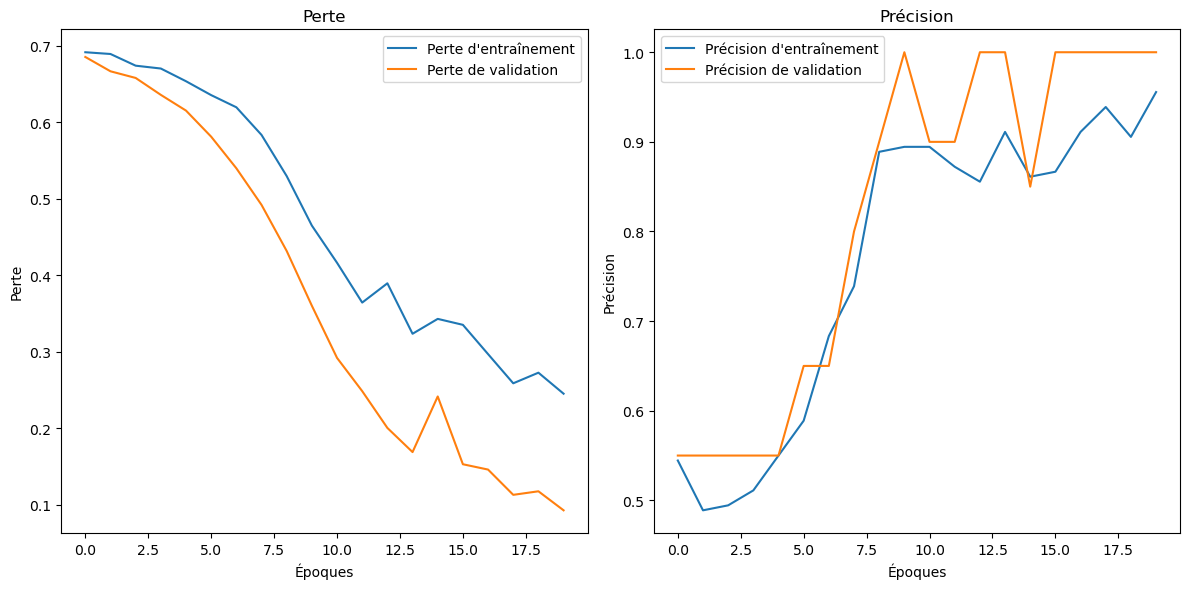

In [49]:
def plot_learning_curves(history):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Perte d\'entraînement')
        plt.plot(history.history['val_loss'], label='Perte de validation')
        plt.xlabel('Époques')
        plt.ylabel('Perte')
        plt.title('Perte')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
        plt.plot(history.history['val_accuracy'], label='Précision de validation')
        plt.xlabel('Époques')
        plt.ylabel('Précision')
        plt.title('Précision')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_learning_curves(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


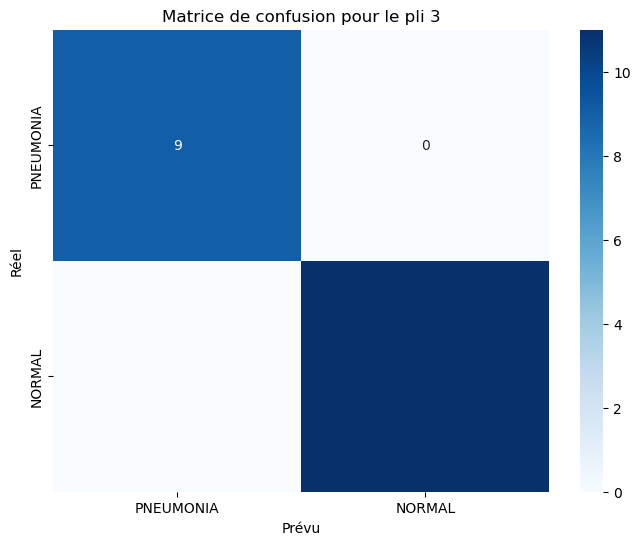

Matrice de confusion pour le pli 3:
 [[ 9  0]
 [ 0 11]]
Rapport de classification pour le pli 3:
               precision    recall  f1-score   support

   PNEUMONIA       1.00      1.00      1.00         9
      NORMAL       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [51]:
def matrice_de_confusion():
    y_pred = (model.predict(x_val_fold) > 0.5).astype("int32")
    cm = confusion_matrix(y_val_fold, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Réel')
    plt.xlabel('Prévu')
    plt.title(f'Matrice de confusion pour le pli {fold}')
    plt.show()
    print(f"Matrice de confusion pour le pli {fold}:\n", cm)

    cr = classification_report(y_val_fold, y_pred, target_names=['PNEUMONIA', 'NORMAL'])
    print(f"Rapport de classification pour le pli {fold}:\n", cr)

matrice_de_confusion()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


UnboundLocalError: cannot access local variable 'fold' where it is not associated with a value

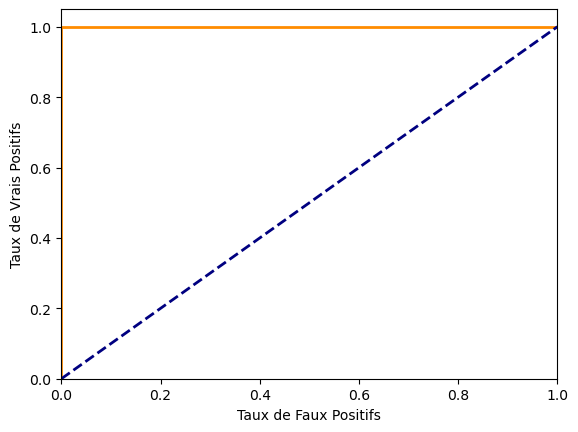

In [57]:
def roc():
    fpr, tpr, _ = roc_curve(y_val_fold, (model.predict(x_val_fold) > 0.5).astype("int32"))
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (aire = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title(f'Courbe ROC pour le pli {fold}')
    plt.legend(loc='lower right')
    plt.show()
    
    fold += 1
    print(f"Précision moyenne sur les {n_folds} plis : {np.mean(fold_accuracies)*100:.2f}%")

roc()

In [59]:
# Entraîner le modèle final sur l'ensemble des données
print("Entraînement du modèle final sur l'ensemble des données...")
datagen_final = ImageDataGenerator(zoom_range=0.1, shear_range=0.1)
datagen_final.fit(x_train)
model_final = create_model()
history_final = model_final.fit(datagen_final.flow(x_train, y_train, batch_size=batch_size),
                                epochs=epochs,
                                validation_data=(x_train, y_train),
                                callbacks=[reduce_lr, early_stop])

Entraînement du modèle final sur l'ensemble des données...
Définition du modèle...
Modèle défini.
Compilation du modèle...
Modèle compilé
Modèle construit
Résumé du modèle :


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,581 (295.24 KB)

 Trainable params: 75,581 (295.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.5096 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5081 - loss: 0.6887 - val_accuracy: 0.5000 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5057 - loss: 0.6830 - val_accuracy: 0.5000 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5153 - loss: 0.6735 - val_accuracy: 0.5000 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5441 - loss: 0.6529 - val_accuracy: 0.5000 - val_loss: 0.6361 - learning_rate: 0.0010


In [61]:
# Évaluation du modèle final
scores_final = model_final.evaluate(x_train, y_train, verbose=0)
print(f"Précision du modèle final: {scores_final[1]*100:.2f}%")
print(f"Perte du modèle final: {scores_final[0]:.4f}")

Précision du modèle final: 50.00%
Perte du modèle final: 0.6839


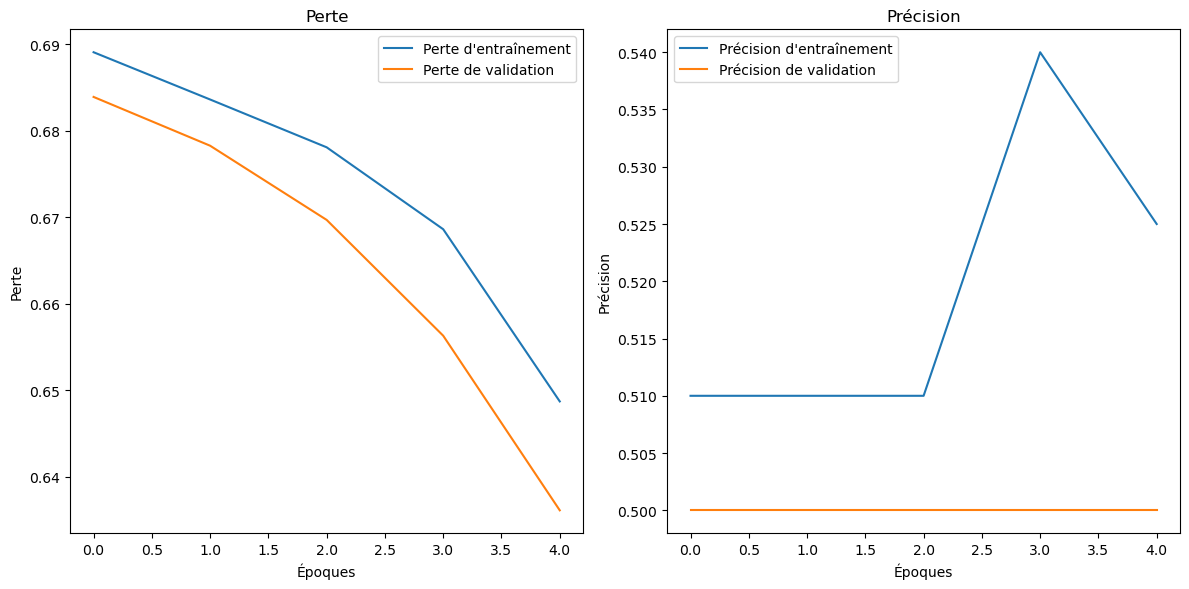

In [63]:
plot_learning_curves(history_final)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


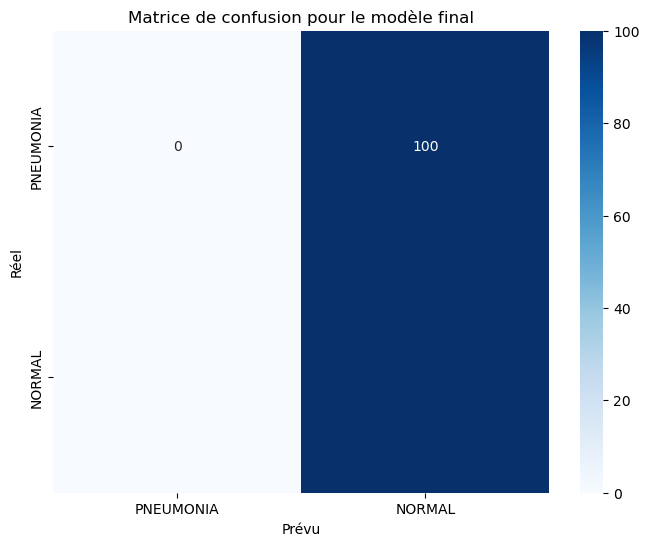

Matrice de confusion pour le modèle final:
 [[  0 100]
 [  0 100]]
Rapport de classification pour le modèle final:
               precision    recall  f1-score   support

   PNEUMONIA       0.00      0.00      0.00       100
      NORMAL       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
def matrice_de_confusion2():
    y_pred_final = (model_final.predict(x_train) > 0.5).astype("int32")
    cm_final = confusion_matrix(y_train, y_pred_final)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Réel')
    plt.xlabel('Prévu')
    plt.title('Matrice de confusion pour le modèle final')
    plt.show()
    print(f"Matrice de confusion pour le modèle final:\n", cm_final)
    cr_final = classification_report(y_train, y_pred_final, target_names=['PNEUMONIA', 'NORMAL'])
    print(f"Rapport de classification pour le modèle final:\n", cr_final)

matrice_de_confusion2()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


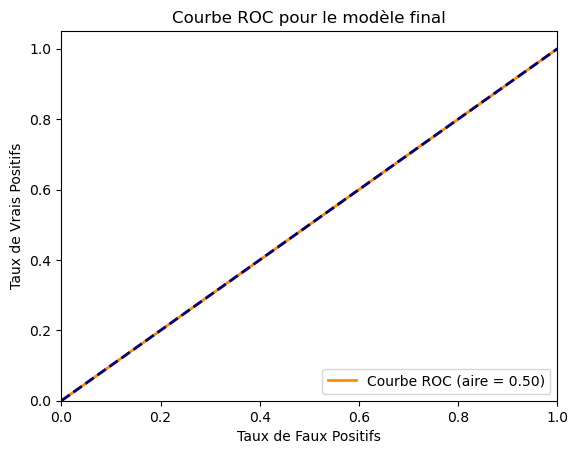

In [71]:
def roc2():
    # Courbe ROC pour le modèle final
    fpr_final, tpr_final, _ = roc_curve(y_train, (model_final.predict(x_train) > 0.5).astype("int32"))
    roc_auc_final = auc(fpr_final, tpr_final)
    plt.figure()
    plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'Courbe ROC (aire = {roc_auc_final:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC pour le modèle final')
    plt.legend(loc='lower right')
    plt.show()

roc2()

Affichage des prédictions simples...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


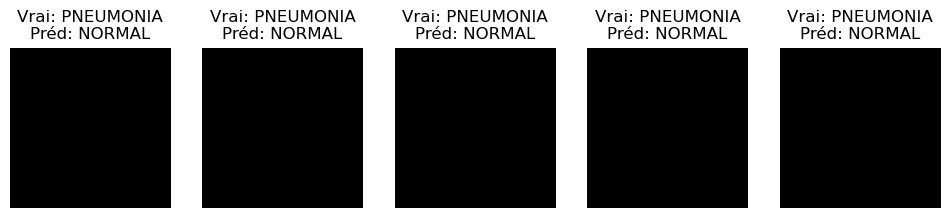

In [73]:
# Fonction pour afficher les prédictions
def display_predictions_simple(model, x_data, y_data, num_images=5):
    print("Affichage des prédictions simples...")
    predictions = (model.predict(x_data) > 0.5).astype("int32")
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_data[i].astype(np.uint8))
        plt.title(f"Vrai: {['PNEUMONIA', 'NORMAL'][y_data[i]]}\nPréd: {['PNEUMONIA', 'NORMAL'][predictions[i][0]]}")
        plt.axis('off')
    plt.show()

display_predictions_simple(model_final, x_train, y_train)

Affichage de l'histogramme des prédictions...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


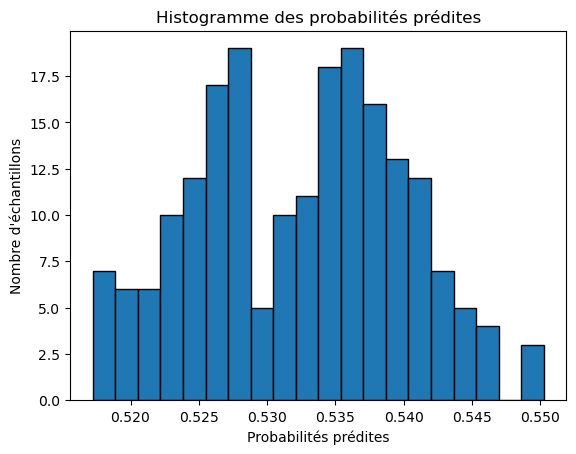

In [75]:
# Fonction pour afficher l'histogramme des prédictions
def plot_prediction_histogram(model, x_data, bins=20):
    print("Affichage de l'histogramme des prédictions...")
    predictions = model.predict(x_data)
    plt.hist(predictions, bins=bins, edgecolor='black')
    plt.xlabel('Probabilités prédites')
    plt.ylabel('Nombre d\'échantillons')
    plt.title('Histogramme des probabilités prédites')
    plt.show()

plot_prediction_histogram(model_final, x_train)